In [3]:
import ml_mr.simulation as mr_sim
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Serialization needs to use dill instead of pickle
# if custom functions are used.
import dill as pickle

In [2]:
pip install dill

Note: you may need to restart the kernel to use updated packages.


In [4]:
sim = mr_sim.Simulation(100_000)

sim.parameters["h2"] = 0.5
sim.parameters["n_variants"] = 20

sim.parameters["ux_effect"] = 0.25
sim.parameters["uy_effect"] = -0.7
sim.parameters["xy_effect"] = 0.3  # Target parameter

# Noise
@mr_sim.variable
def x_e_variance(sim):
    """Variance for the environmental component of the exposure."""
    target = 1 - sim.parameters["h2"] - sim.parameters["ux_effect"] ** 2
    if target < 0:
        raise ValueError("Unacheivable value.")
    return target
sim.add_sim_parameter(x_e_variance)

sim.parameters["y_e_std"] = 1

In [5]:
# Standard normal for the confounder
sim.add_variable(mr_sim.Normal("u", 0, 1))

# We generate the variant frequencies "outside" of
# the simulation model because it's not very important.
# This could also be done using real simulation variables
# to ensure resampling.
# We still record them as (fixed) simulation parameters.
@mr_sim.variable
def variant_frequencies(sim):
    return np.random.uniform(
        0.2,
        0.4,
        size=sim.get_sim_parameter("n_variants")
        # equivalently: sim.parameters["n_variants"]
    )
sim.add_sim_parameter(variant_frequencies)

freqs = sim.parameters["variant_frequencies"]
# We now simulate independant genetic variants.
variants = []
for i in range(sim.parameters["n_variants"]):
    variant = mr_sim.Variant(f"v{i+1}", freqs[i])
    variants.append(variant)

sim.add_variables(variants)

# We simulate variant effects.
# Note that these effects will yield the desired heritability
# only if var(g) = 1 (i.e. if the variants have been scaled).
# sim.add_sim_parameter(
#     mr_sim.Normal(
#         "gx_effects",
#         mu=0,
#         sigma=np.sqrt(sim.parameters["h2"] / sim.parameters["n_variants"]),
#         size=sim.parameters["n_variants"]
#     )
# )
@mr_sim.variable
def gx_effects(sim):
    import torch
    d = np.random.dirichlet(np.ones(sim.parameters["n_variants"]))
    return np.sqrt(d * sim.parameters["h2"])

sim.add_sim_parameter(gx_effects)

    
# We now have everything to simulate the exposure.
@mr_sim.variable
def exposure(sim):
    variant_effects = sim.parameters["gx_effects"]
    
    x = 0
    for i in range(sim.parameters["n_variants"]):
        variant = sim.get_variable_data(f"v{i+1}")
        scaled_variant = (variant - np.mean(variant)) / np.std(variant)
        effect = variant_effects[i]
        
        x += effect * scaled_variant
        
    print("Var_G(X) = {}".format(np.var(x)))
    
    # Add effect of counfounder.
    x += sim.parameters["ux_effect"] * sim.get_variable_data("u")
    
    # Add residual noise.
    x += np.random.normal(
        0,
        scale=np.sqrt(sim.parameters["x_e_variance"]),
        size=sim.n
    )
    
    print("Var(X) = {}".format(np.var(x)))
    
    return x
    

# And the outcome.
@mr_sim.variable
def outcome(sim):
    return (
        sim.parameters["xy_effect"] * sim.get_variable_data("exposure") +
        sim.parameters["uy_effect"] * sim.get_variable_data("u") +
        np.random.normal(0, scale=sim.parameters["y_e_std"], size=sim.n)
    )


sim.add_variable(exposure)
sim.add_variable(outcome)

Var_G(X) = 0.49993619511224596
Var(X) = 1.0026549111395178


In [6]:
# Simulations can be saved to disk as pairs of JSON + CSV files.
# The JSON contains simulation parameters and the CSV files contains
# simulated data.
sim.save(0)

# The resample method can be used to run the simulation again.
sim.resample()
sim.save(1)
!ls

Var_G(X) = 0.49651195753498
Var(X) = 0.9979165382507383
basic_simulation_model.ipynb	 mr_simulation_0_sim_parameters.json
basic_sweep.json		 mr_simulation_1_sim_data.csv.gz
basic_sweep_deterministic.json	 mr_simulation_1_sim_parameters.json
mdn_tests.ipynb			 sweep_with_blob.json
mr_simulation_0_sim_data.csv.gz


In [7]:
# The individual level data is stored as a pandas dataframe.
sim._data

,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v13,v14,v15,v16,v17,v18,v19,v20,exposure,outcome
0,-0.627194,0,1,0,0,0,1,0,1,1,...,0,1,0,1,0,0,0,0,0.123786,0.703634
1,0.110084,0,1,0,0,1,1,1,2,0,...,0,0,2,1,1,0,1,0,-0.162757,-0.957049
2,-1.533555,0,1,1,0,0,0,1,0,0,...,1,1,1,0,0,0,1,2,-0.555823,1.931973
3,0.879858,0,1,1,2,1,1,0,1,0,...,1,1,0,0,0,0,0,0,0.085944,-1.596860
4,0.705755,0,2,0,0,0,0,0,0,1,...,2,2,0,0,1,1,0,0,0.673296,-1.044242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.199483,0,0,1,1,2,0,0,2,1,...,1,0,1,2,1,0,1,1,1.063834,-0.831296
99996,-0.724842,0,1,0,0,0,0,0,1,2,...,0,1,2,0,2,0,0,1,-0.328286,1.710070
99997,-0.004412,0,1,1,0,0,1,1,2,2,...,0,0,1,0,0,1,1,1,0.172131,0.227623
99998,0.258703,0,1,0,0,1,0,0,1,0,...,1,1,0,1,0,0,1,1,-0.369941,0.140103


In [8]:
# Check how close we are to the desired heritability.
res = sm.OLS(
    sim.get_variable_data("exposure"),
    sm.add_constant(  # Adds intercept
        sim._data[[f"v{i+1}" for i in range(20)]]
    )
).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     5062.
Date:                Wed, 02 Jul 2025   Prob (F-statistic):               0.00
Time:                        13:53:49   Log-Likelihood:            -1.0682e+05
No. Observations:              100000   AIC:                         2.137e+05
Df Residuals:                   99979   BIC:                         2.139e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4580      0.009   -266.120      0.000      -2.476      -2.440
v1             0.0407      0.004     11.115      0.000       0.034       0.048
v2             0.4478      0.004    125.285      0.000       0.441       0.455
v3             0.2690      0.004     75.347      0.000       0.262       0.276
v4             0.3880      0.004    101.385      0.000       0.380       0.395
v5             0.3163      0.003     92.005      0.000       0.310       0.323
v6             0.1291      0.003     37.097      0.000       0.122       0.136
v7             0.1298      0.004     34.947      0.000       0.122       0.137
v8             0.1778      0.003     54.634      0.000       0.171       0.184
v9             0.1661      0.004     43.832      0.000       0.159       0.174
v10            0.2911      0.003     85.227      0.000       0.284       0.298
v11            0.1573      0.003     46.605      0.000       0.151       0.164
v12            0.4832      0.004    128.920      0.000       0.476       0.491
v13            0.3284      0.004     91.466      0.000       0.321       0.335
v14            0.0223      0.003      6.803      0.000       0.016       0.029
v15            0.1185      0.003     35.227      0.000       0.112       0.125
v16            0.1207      0.004     32.561      0.000       0.113       0.128
v17            0.2811      0.004     73.329      0.000       0.274       0.289
v18            0.0815      0.004     22.699      0.000       0.074       0.089
v19            0.2355      0.003     72.288      0.000       0.229       0.242
v20            0.2578      0.003     79.341      0.000       0.251       0.264
==============================================================================
Omnibus:                        0.610   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.737   Jarque-Bera (JB):                0.621
Skew:                          -0.002   Prob(JB):                        0.733
Kurtosis:                       2.989   Cond. No.                         12.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

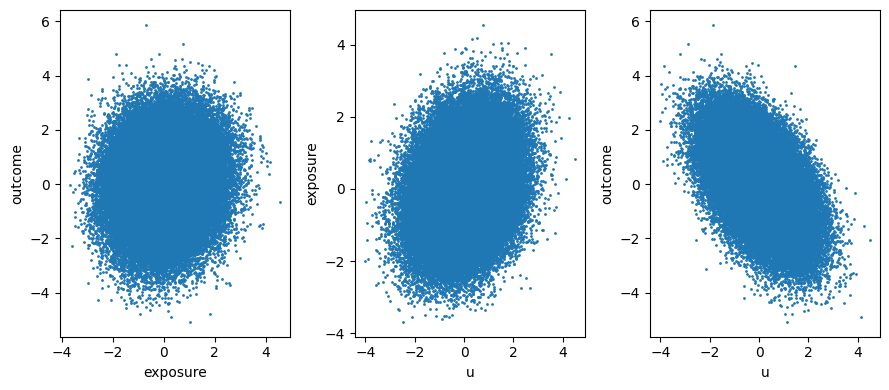

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(9, 4))

pairs = (
    ("exposure", "outcome"),
    ("u", "exposure"),
    ("u", "outcome")
)

for i, (x, y) in enumerate(pairs):
    axes[i].scatter(sim.get_variable_data(x), sim.get_variable_data(y), s=1)
    axes[i].set_xlabel(x)
    axes[i].set_ylabel(y)
    
plt.tight_layout()

In [10]:
# Simulations can be saved using the "dill" package.
# This allows easy sharing of simulation models.
# The original data will be saved.
sim.save_pickle("sim.pkl")
sim2 = mr_sim.Simulation.load_pickle("sim.pkl")
sim2._data

,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v13,v14,v15,v16,v17,v18,v19,v20,exposure,outcome
0,-0.627194,0,1,0,0,0,1,0,1,1,...,0,1,0,1,0,0,0,0,0.123786,0.703634
1,0.110084,0,1,0,0,1,1,1,2,0,...,0,0,2,1,1,0,1,0,-0.162757,-0.957049
2,-1.533555,0,1,1,0,0,0,1,0,0,...,1,1,1,0,0,0,1,2,-0.555823,1.931973
3,0.879858,0,1,1,2,1,1,0,1,0,...,1,1,0,0,0,0,0,0,0.085944,-1.596860
4,0.705755,0,2,0,0,0,0,0,0,1,...,2,2,0,0,1,1,0,0,0.673296,-1.044242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.199483,0,0,1,1,2,0,0,2,1,...,1,0,1,2,1,0,1,1,1.063834,-0.831296
99996,-0.724842,0,1,0,0,0,0,0,1,2,...,0,1,2,0,2,0,0,1,-0.328286,1.710070
99997,-0.004412,0,1,1,0,0,1,1,2,2,...,0,0,1,0,0,1,1,1,0.172131,0.227623
99998,0.258703,0,1,0,0,1,0,0,1,0,...,1,1,0,1,0,0,1,1,-0.369941,0.140103


In [11]:
# And resampling should also work as expected!
sim2.resample()
sim2._data

Var_G(X) = 0.5039810684686047
Var(X) = 1.0085408954673676


,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v13,v14,v15,v16,v17,v18,v19,v20,exposure,outcome
0,-0.505761,0,1,1,0,0,0,0,1,2,...,1,0,1,0,0,1,0,1,0.126297,1.682179
1,-0.150293,0,1,1,1,0,0,0,0,1,...,0,1,1,1,0,0,0,1,-1.871866,-3.456079
2,0.565889,0,1,0,0,0,1,1,1,1,...,0,1,1,0,1,0,1,0,1.112744,-0.909687
3,-0.899695,0,0,1,0,1,2,1,1,0,...,1,1,1,1,1,0,1,1,1.276332,-0.465735
4,-1.890710,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,1,-1.751059,1.376303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-2.141644,0,1,0,1,0,0,0,1,0,...,1,0,1,0,1,1,1,1,-0.218722,2.318886
99996,-0.674594,0,1,1,0,0,2,1,0,1,...,0,0,1,1,0,2,2,2,2.246751,1.381994
99997,0.322232,2,0,0,0,2,0,0,0,1,...,0,2,0,0,1,0,0,1,0.809199,-0.343769
99998,0.772486,0,0,1,0,0,0,0,1,1,...,1,1,0,0,0,0,0,1,-0.366629,1.844848
